counting lines in file...
There are 100001 Packets.
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
Training Kitsune:
1000
2000
3000
4000
5000
origional ids of the features
[[35]]
origional ids of the features
[[48, 20, 41, 27, 34]]
origional ids of the features
[[71, 78, 85, 92, 99]]
origional ids of the features
[[21, 28]]
origional ids of the features
[[42, 49]]
origional ids of the features
[[91, 98, 84, 70, 77]]
origional ids of the features
[[61, 58, 52, 55, 64, 63, 60, 57, 51, 54]]
origional ids of the features
[[81, 67, 74, 82, 68, 75, 88, 95, 89, 96]]
origional ids of the features
[[39, 46, 14, 45, 11, 38]]
origional ids of the features
[[32, 18, 25, 8, 31, 5, 24, 2, 17]]
origional ids of the features
[[13, 44, 10, 37]]
origional ids of the features
[[87, 94, 80, 66, 73]]
origional ids of the features
[[7, 30, 4, 23, 1, 16]]
origional ids of the features
[[90, 97, 83, 69, 76, 40, 47, 33, 19, 26]]
origional ids of the features
[[12, 43, 9, 36]]
origional ids of the featu

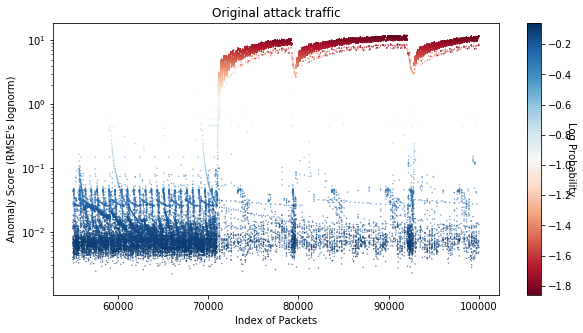

In [27]:
import os
import subprocess
import csv
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.mixture import GaussianMixture 
from Kitsune import Kitsune

%matplotlib inline
matplotlib_is_available = True
try:
    from matplotlib import pyplot as plt
except ImportError:
    print("Will skip plotting; matplotlib is not available.")
    matplotlib_is_available = False

# File location
path = "100000_packets_mirai.tsv" #the pcap, pcapng, or tsv file to process.
packet_limit = np.Inf #the number of packets to process

# KitNET params:
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself) 

# Build Kitsune
K = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace)

# Train Kitsune
print("Training Kitsune:")
RMSEs = []
i = 0
while True:
    i+=1
    if i % 1000 == 0:
        print(i)
    rmse, _ = K.proc_next_packet()
    if rmse == -1:
        break
    RMSEs.append(rmse)
    
threshold = max(RMSEs[0: 69999])

labels = []     
y_all_blackbox = list([0]*(FMgrace + ADgrace + 1))
for line in open("100000_labels_mirai.tsv"): 
    if line.find('0') != -1: 
        labels.append(0)
    elif line.find('1') != -1: 
        labels.append(1)
        
positive_sum = 30001 
positive_num = 0
positive_train = int(positive_sum * 0.6)
train_num = 0
positive_validation = int(positive_sum * 0.2)
validation_num = 0
positive_test = positive_sum - positive_train - positive_validation
test_num = 0
vs_1 = 6001 * 1 
vs_2 = 6001 * 2 
vs_3 = 6001 * 3 
vs_4 = 6001 * 4 
vs_5 = min(6001 * 5, positive_sum) 
vs_1_num = 0
vs_2_num = 0
vs_3_num = 0
vs_4_num = 0
vs_5_num = 0
num = 0
FP = 0
print(positive_train)
print(positive_validation)
print(positive_test)
# threshold = 0
# for i in range(FMgrace + ADgrace + 1, 100000):
#     if labels[i] == 0:   
#         threshold = max(threshold,RMSEs[i])
for i in range(FMgrace + ADgrace + 1, 100000):
    if labels[i] == 0:
        if RMSEs[i] > threshold: 
            FP += 1
    elif labels[i] == 1:
        num += 1
        if RMSEs[i] > threshold: 
            positive_num += 1
            if num <= positive_train:
                train_num += 1
            elif num <= positive_train + positive_validation:
                validation_num += 1
            else:
                test_num += 1
            if num > positive_sum - vs_1:
                vs_1_num += 1
            if num > positive_sum - vs_2:
                vs_2_num += 1    
            if num > positive_sum - vs_3:
                vs_3_num += 1
            if num > positive_sum - vs_4:
                vs_4_num += 1    
            if num > positive_sum - vs_5:
                vs_5_num += 1 
    if RMSEs[i] > threshold:
        y_all_blackbox.append(1)
    elif RMSEs[i] <= threshold:
        y_all_blackbox.append(0)
original_TPR = positive_num / positive_sum
Precision = positive_num / (positive_num + FP)
F_score = 2 * original_TPR * Precision / (original_TPR + Precision)

train_TPR = train_num / positive_train
validation_TPR = validation_num / positive_validation
test_TPR = test_num / positive_test
print('Threshold: {0}'.format(threshold))
print('Original_TPR (Recall): {0:0.4f}'.format(original_TPR)) 
print('Precision: {0:0.4f}'.format(Precision)) 
print('F-score: {0:0.4f}'.format(F_score)) 
print('Train_TPR: {0:0.4f}  Validation_TPR: {1:0.4f}  Test_TPR: {2:0.4f}'.format(train_TPR, validation_TPR, test_TPR)) 
vs_1_TPR = vs_1_num / vs_1
vs_2_TPR = vs_2_num / vs_2
vs_3_TPR = vs_3_num / vs_3
vs_4_TPR = vs_4_num / vs_4
vs_5_TPR = vs_5_num / vs_5
print('vs_1_TPR: {0:0.4f}  vs_2_TPR: {1:0.4f}  vs_3_TPR: {2:0.4f}  vs_4_TPR: {3:0.4f}  vs_5_TPR: {4:0.4f}'.format(vs_1_TPR, vs_2_TPR, vs_3_TPR, vs_4_TPR, vs_5_TPR)) 
print(positive_num)
print(positive_sum)

# Here we demonstrate how one can fit the RMSE scores to a log-normal distribution (useful for finding/setting a cutoff threshold \phi)
from scipy.stats import norm
benignSample = np.log(RMSEs[FMgrace+ADgrace+1:])
logProbs = norm.logsf(np.log(RMSEs), np.mean(benignSample), np.std(benignSample)) 

# plot the RMSE anomaly scores
print("Plotting results")
plt.figure(figsize=(10,5))
fig = plt.scatter(range(FMgrace+ADgrace+1,len(RMSEs)),RMSEs[FMgrace+ADgrace+1:],s=0.1,c=logProbs[FMgrace+ADgrace+1:],cmap='RdBu')
plt.yscale("log")
plt.title("Original attack traffic")
plt.ylabel("Anomaly Score (RMSE's lognorm)")
plt.xlabel("Index of Packets")
figbar=plt.colorbar()
figbar.ax.set_ylabel('Log Probability\n\n', rotation=270)
plt.savefig("Mirai_kitsune_before.pdf")
plt.show()


In [26]:
print((1540450841.432895000-1540450841.418179000)*6+1540450841.418179000)

1540450841.5064745


In [23]:
print((1540450841.473288000-1540450841.432895000)*8+1540450841.5359063)

1540450841.8590512


In [25]:
a=[1,2,3]
b=[2]
print(b)
b=a
print(b)

[2]
[1, 2, 3]


In [2]:
def encode(s):
    return ' '.join([bin(ord(c)).replace('0b', '') for c in s])

def find_all(sub,s):
    index_list = []
    index = s.find(sub)
    while index != -1:
        index_list.append(index)
        index = s.find(sub,index+1)
        
    if len(index_list) > 0:
        return index_list
    else:
        return -1

def get_next_vector():
    row = tsv_reader.__next__()
    #print(row)
    rowStr = ','.join(row)
    #print(rowStr)
    rowStrEnc = encode(rowStr)
#     print(rowStrEnc)
#     print()
    index_list = find_all(' 101100',rowStrEnc) #find ','
    mask = '0'
    mask = mask.ljust(len(rowStrEnc),'0')
    mask = list(mask)
    modify_idx = [2,3,10,11,12,13,14,15,16,17,18] 
    #modify_idx = [2,3,4,5,14,16,17,18] 
    for i in modify_idx:
        if i == 0:
            head = 0
        else:
            head = index_list[i-1]+len(' 101100')
        if i == 18:
            tail = len(rowStrEnc)
        else:
            tail = index_list[i]
        for j in range(head,tail):
            mask[j]='1'
    index_list = find_all(' 111010',rowStrEnc) #find ':'
    for i in index_list:
        head = i
        tail = head+len(' 111010')
        for j in range(head,tail):
            mask[j]='0'
    index_list = find_all(' 101110',rowStrEnc) #find '.'
    for i in index_list:
        head = i
        tail = head+len(' 101110')
        for j in range(head,tail):
            mask[j]='0'
    mask = ''.join(mask)
#     print(mask)
#     print()
    row_enc_mask = rowStrEnc
    row_enc_mask = list(row_enc_mask)
    for i in range(len(rowStrEnc)):
        if rowStrEnc[i]==' ':
            row_enc_mask[i]='0'
        elif mask[i]=='0':
            row_enc_mask[i]='0'
    row_enc_mask=''.join(row_enc_mask)
#     print(row_enc_mask) 
#     print()
    return row_enc_mask, rowStrEnc, mask

f = open('Mirai_vector.txt','w')
f1 = open('Mirai_rowStrEnc.txt','w')
f2 = open('Mirai_mask.txt','w')
with open('100000_packets_mirai.tsv', 'r', encoding="utf8") as tsv_in, open("100000_labels_mirai.tsv",'r') as x:
    tsv_reader = csv.reader(tsv_in, delimiter='\t')
    row = tsv_reader.__next__()
    print(row)
    line1=x.readlines()
    for i in range(0,100000):
        #print(i)
        vector, rowStrEnc, mask = get_next_vector()
        f.write(vector+'\n')
        if line1[i].find('1') != -1:
            f1.write(rowStrEnc+'\n')
            f2.write(mask+'\n')
f.close()
f1.close()
f2.close()

#find Max，Mirai 968
max_vector_len=0
for line in open("Mirai_vector.txt"):
    max_vector_len=max(max_vector_len,len(line)-1) 
print("max_vector_len={0}".format(max_vector_len))

#The length is unified to the maximum value, and mal and ben are stored separately
#mirai
f1 = open('Mirai_vector_mal.txt','w')
f2 = open('Mirai_vector_ben.txt','w')
with open("100000_labels_mirai.tsv",'r') as x ,open("Mirai_vector.txt",'r') as y:
    line1=x.readlines()
    line2=y.readlines()
    for i in range(0,100000):
        ss=line2[i]
        ss=ss.strip('\n')
        ss=ss.ljust(max_vector_len,'0')
        if line1[i].find('0') != -1:
            f2.write(ss+'\n')
        elif line1[i].find('1') != -1:
            f1.write(ss+'\n')
f1.close()
f2.close()

['frame.time_epoch', 'frame.len', 'eth.src', 'eth.dst', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport', 'udp.srcport', 'udp.dstport', 'icmp.type', 'icmp.code', 'arp.opcode', 'arp.src.hw_mac', 'arp.src.proto_ipv4', 'arp.dst.hw_mac', 'arp.dst.proto_ipv4', 'ipv6.src', 'ipv6.dst']
max_vector_len=968


In [6]:
print("max_vector_len={0}".format(max_vector_len))

m=968


In [3]:
%matplotlib inline

In [6]:
def extract(v):
    return v.data.storage().tolist()

def init_weights(m):
    #print(m)
    if type(m) == nn.Linear:
        #nn.init.xavier_normal_(m.weight.data, gain=1)
        nn.init.xavier_uniform_(m.weight.data, gain=1)
        
class Generator(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size, f): 
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
#         self.map2 = nn.Linear(hidden_size, hidden_size)
#         self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.Linear(hidden_size, output_size)
        #self.map1 = nn.Sequential(nn.Linear(input_size, hidden_size), nn.LeakyReLU(True),)
        #self.map4 = nn.Sequential(nn.Linear(hidden_size, output_size), nn.LeakyReLU(True),)
        self.f = f 
 
    def forward(self, x):
        x = self.f(self.map1(x))
#         x = self.f(self.map2(x))
#         x = self.f(self.map3(x))
        return self.f(self.map4(x))

class Discriminator(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        #self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        #self.map1 = nn.Sequential(nn.Linear(input_size, hidden_size), nn.LeakyReLU(True),)
        #self.map3 = nn.Sequential(nn.Linear(hidden_size, output_size), nn.LeakyReLU(True),)
        self.f = f 

    def forward(self, x):
        x = self.f(self.map1(x))
        #x = self.f(self.map2(x))
        return self.map3(x)

def build_blackbox_detector(blackbox):
    if blackbox is 'MLP':
        blackbox_detector = MLPClassifier(hidden_layer_sizes=(50,), max_iter=30, alpha=1e-4,
                                          solver='sgd', verbose=0, tol=1e-4, random_state=1,
                                          learning_rate_init=.1)
    return blackbox_detector
    
def load_data(filename):
    x = []
    with open(filename,'r') as data:
        lines = data.readlines()
        for line in lines:
            line=line.strip('\n')
            x.append(list(line))
    x = np.array(x,dtype=np.float64)
    return x

def load_data_str(filename):
    x = []
    with open(filename,'r') as data:
        while True:
            line = data.readline() 
            if not line:
                break
            x.append(line)
    return x

def my_hash(x):
    return str(x%256)
    
def encode(s):
    return ' '.join([bin(ord(c)).replace('0b', '') for c in s])
 
def decode(s, original_s):
    binary_b = []
    binary_o = []
    for b in s.split(' '):
        binary_b.append(int(b, 2))
    for o in original_s.split(' '):
        binary_o.append(int(o, 2))    
    chr_b = []
    for i in range(0, len(binary_b)):
        chr_i = chr(binary_b[i])
        chr_o = chr(binary_o[i])
        if not chr_i.isdigit() and not chr_i.islower() and chr_i != '.' and chr_i != ':' and chr_i != ',':
            chr_i = my_hash(binary_b[i])
        if (chr_i == '.' and chr_o != '.') or (chr_i == ':' and chr_o != ':') or (chr_i == ',' and chr_o != ','):
            chr_i = my_hash(binary_b[i])
        chr_b.append(chr_i)
    chr_b = ''.join(chr_b) 
    return chr_b
    
def gen_vectors_2_packets(gen_examples_numpy, idx, K, threshold): #idx is the format of [1 1 1]
    rowStrEncs = load_data_str('Mirai_rowStrEnc.txt')
    masks = load_data_str('Mirai_mask.txt')
    gen_examples_str = []
    y_kitsune = []
    #Rmses = []
    Row_restore = []
    Row_split = []
    for each_example in gen_examples_numpy:
        one_example = ''
        for each_01 in each_example:
            one_example = one_example + str(each_01)
        gen_examples_str.append(one_example)
    
    for i in range(len(gen_examples_str)):
        length = len(rowStrEncs[idx[i]])-1 #There is'\n' in the end
        rowStrEnc = rowStrEncs[idx[i]][0:length]
        row_restore = list(gen_examples_str[i][0:length])
        for j in range(length):
            if rowStrEnc[j]==' ':
                row_restore[j]=' '
            elif masks[idx[i]][j]=='0':
                row_restore[j]=rowStrEnc[j]
        row_restore = ''.join(row_restore)
        Row_restore.append(row_restore)
        row_dec_mask = decode(row_restore, rowStrEnc)
        row_split = row_dec_mask.split(',')
        Row_split.append(row_split)
        rmse = K.proc_any_packet(row_split)
        #Rmses.append(rmse)
        if rmse > threshold:
            y_kitsune.append(1)
        else:
            y_kitsune.append(0) 

#     print(Row_restore[-1])
#     print("3************************************************")
#     print(Row_split[-1])
#     print("4************************************************")
    return np.array(y_kitsune), Row_split

def compute_TPR(y_kitsune, y_mal): #y_kitsune is in the format of [1 1 1], y_mal is in the format of [[1] [1] [1]]
    positive_sum = y_mal.shape[0]
    positive_num = 0
    for i in range (0, y_kitsune.shape[0]):
        if y_kitsune[i] == y_mal[i][0]:
            positive_num += 1
    return positive_num / positive_sum

# Model parameters
feature_dims = max_vector_len
z_dims = 20
g_input_size = feature_dims + z_dims
g_output_size = feature_dims
g_hidden_size = int(math.sqrt(g_input_size+g_output_size)+6) 
d_input_size = g_output_size
d_output_size = 1
d_hidden_size = int(math.sqrt(d_input_size+d_output_size)+6) 

epochs = 100+1
batch_size = 32
print_interval = 10 

d_learning_rate = 5e-5
g_learning_rate = 5e-5
sgd_momentum = 0.9

clip = [-0.01, 0.01] 
#LAMBDA = 10 # Gradient penalty lambda hyperparameter

d_steps = 5 # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1 

discriminator_activation_function = torch.sigmoid
generator_activation_function = torch.sigmoid

benign = torch.zeros([batch_size,1]).reshape(-1)
mal = torch.ones([batch_size,1]).reshape(-1)

G = Generator(input_size=g_input_size,
              hidden_size=g_hidden_size,
              output_size=g_output_size,
              f=generator_activation_function)
G.apply(init_weights)
D = Discriminator(input_size=d_input_size,
                  hidden_size=d_hidden_size,
                  output_size=d_output_size,
                  f=discriminator_activation_function)  
D.apply(init_weights)
criterion = nn.BCELoss()

d_optimizer = optim.RMSprop(D.parameters(), lr=d_learning_rate)
g_optimizer = optim.RMSprop(G.parameters(), lr=g_learning_rate)
#d_optimizer = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))
#g_optimizer = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))

# Load the dataset
xmal = load_data('Mirai_vector_mal.txt')
ymal = np.ones((xmal.shape[0], 1), dtype=np.int)
xben = load_data('Mirai_vector_ben.txt')
yben = np.zeros((xben.shape[0], 1), dtype=np.int)
#The restore operation needs to know the serial number of the sample in order to correspond to rowStrEnc and mask, so the training set, verification set and test set cannot be randomly allocated. The division ratio is tentatively set to 0.6:0.2:0.2
train_size = int(xmal.shape[0] * 0.6)
validation_size = int(xmal.shape[0] * 0.2)
test_size = xmal.shape[0] - train_size - validation_size
xtrain_mal = xmal[0:train_size, :]
xvalidation_mal = xmal[train_size:train_size+validation_size, :]
xtest_mal = xmal[train_size+validation_size:, :]
ytrain_mal = ymal[0:train_size, :]
yvalidation_mal = ymal[train_size:train_size+validation_size, :]
ytest_mal = ymal[train_size+validation_size:, :]
train_size_ben = int(xben.shape[0] * 0.6)
#The benign data is divided into training set and test set, divided into 0.6:0.4
xtrain_ben = xben[0:train_size_ben, :]
xtest_ben = xben[train_size_ben:, :]
ytrain_ben = yben[0:train_size_ben, :]
ytest_ben = yben[train_size_ben:, :]
idx_train = np.array(range(0, train_size), dtype=np.int)
idx_validation = np.array(range(train_size, train_size+validation_size), dtype=np.int)
idx_test = np.array(range(train_size+validation_size, xmal.shape[0]), dtype=np.int)


#batch_size = 32
#batch_size_xtrain_ben = int(xtrain_ben.shape[0] / (epochs*d_steps))
#batch_size_xtrain_mal_D = int(xtrain_mal.shape[0] / (epochs*d_steps))
#batch_size_xtrain_mal_G = int(xtrain_mal.shape[0] / (epochs*g_steps))
# batch_size_xtrain_ben = 32
# batch_size_xtrain_mal_D = 32
# batch_size_xtrain_mal_G = 32

Train_TPR, Validation_TPR, Test_TPR = [], [], []
Train_TPR.insert(0, train_TPR)
Validation_TPR.insert(0, validation_TPR)
Test_TPR.insert(0, test_TPR)
ytrain_ben_blackbox = [] 
for i in range(0, len(labels)):
    if len(ytrain_ben_blackbox) == train_size_ben:
        break
    if labels[i] == 0:
        ytrain_ben_blackbox.append(y_all_blackbox[i]) #Mirai: The front is benign and the back is malicious, not mixed, so you can take it directly from the front

xtrain_mal = torch.Tensor(xtrain_mal)
xvalidation_mal = torch.Tensor(xvalidation_mal)
xtest_mal = torch.Tensor(xtest_mal)
xtrain_ben = torch.Tensor(xtrain_ben)
xtest_ben = torch.Tensor(xtest_ben)

# Build Kitsune 2
packet_limit = FMgrace + ADgrace + 1
K2 = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace)

# Train Kitsune
print("Training Kitsune 2:")
for i in range(FMgrace + ADgrace + 1):
#             if i % 1000 == 0:
#                 print(i)
    x, y = K2.proc_next_packet() #x, y not used later
index_of_data_D_ben = 0     
index_of_data_D_mal = 0    
index_of_data_G = 0
for epoch in range(epochs):
    for d_index in range(d_steps):
        D.zero_grad() 

        #  1A: Train D on real
#         idx = np.random.randint(0, xtrain_ben.shape[0], batch_size)
        idx = np.array(range(index_of_data_D_ben, index_of_data_D_ben+batch_size))
        index_of_data_D_ben += batch_size
        xben_batch = xtrain_ben[idx]
        yben_batch = np.array(ytrain_ben_blackbox)[idx] 
        d_real_data = Variable(xben_batch)
        d_real_decision = D(d_real_data)
#             print("d_real_decision:{0}".format(d_real_decision.reshape(-1)))
#             d_real_decision = Variable(torch.Tensor(np.ones(d_real_decision.shape)*(d_real_decision.data.numpy() > 0.5)))
        #d_real_error = criterion(d_real_decision.reshape(-1), Variable(torch.Tensor(yben_batch).reshape(-1))) 
        d_real_error = torch.mean(d_real_decision.reshape(-1))
        d_real_error.backward(benign.mean())
        #d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
#        idx = np.random.randint(0, xtrain_mal.shape[0], batch_size) 
        idx = np.array(range(index_of_data_D_mal, index_of_data_D_mal+batch_size))
        index_of_data_D_mal += batch_size
        xmal_batch = xtrain_mal[idx]    
        np.random.seed(0)
        noise = np.random.uniform(0, 1, (batch_size, z_dims))
        d_gen_input = Variable(torch.cat((xmal_batch, torch.Tensor(noise)), 1))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        gen_examples_numpy = np.ones(d_fake_data.shape, dtype=np.int)*(d_fake_data.data.numpy() > 0.5)
        ymal_batch, _ = gen_vectors_2_packets(gen_examples_numpy, idx, K2, threshold)
        d_fake_decision = D(d_fake_data)
#             print("d_fake_decision:{0}".format(d_fake_decision.reshape(-1)))
#             d_fake_decision = Variable(torch.Tensor(np.ones(d_fake_decision.shape)*(d_fake_decision.data.numpy() > 0.5)))
        #d_fake_error = criterion(d_fake_decision.reshape(-1), Variable(torch.Tensor(ymal_batch).reshape(-1))) 
        d_fake_error = torch.mean(d_fake_decision.reshape(-1))
        d_fake_error.backward(mal.mean())
        d_error = d_real_error - d_fake_error
#         d_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
              

        # Clip weights of discriminator
        for p in D.parameters():
            p.data.clamp_(clip[0], clip[1])
        
        # train with gradient penalty
        #gradient_penalty = calc_gradient_penalty(D, d_real_data.data, d_fake_data.data)
        #gradient_penalty.backward()
        ########end

        dre, dfe, d_loss = extract(d_real_error)[0], extract(d_fake_error)[0], extract(d_error)[0]

    for g_index in range(g_steps):
        G.zero_grad()
#         idx = np.random.randint(0, xtrain_mal.shape[0], batch_size)
        idx = np.array(range(index_of_data_G, index_of_data_G+batch_size))
        index_of_data_G += batch_size
        xmal_batch = xtrain_mal[idx]
        np.random.seed(0)
        noise = np.random.uniform(0, 1, (batch_size, z_dims))
        gen_input = Variable(torch.cat((xmal_batch, torch.Tensor(noise)), 1))
        gen_examples = G(gen_input)
        dg_fake_decision = D(gen_examples)
#             print("dg_fake_decision:{0}".format(dg_fake_decision.reshape(-1)))
#             dg_fake_decision = Variable(torch.Tensor(np.ones(dg_fake_decision.shape)*(dg_fake_decision.data.numpy() > 0.5)))
        #g_error = criterion(dg_fake_decision.reshape(-1), Variable(torch.zeros([batch_size,1]).reshape(-1)))
        g_error = torch.mean(dg_fake_decision.reshape(-1))
        g_error.backward(benign.mean())
        g_optimizer.step()  # Only optimizes G's parameters
        g_loss = extract(g_error)[0]

    if epoch % print_interval == 0 and epoch > 0:     
        # Build Kitsune 3
        packet_limit = FMgrace + ADgrace + 1
        K3 = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace)

        # Train Kitsune
        print("Training Kitsune 3:")
        for i in range(FMgrace + ADgrace + 1):
#             if i % 1000 == 0:
#                 print(i)
            x, y = K3.proc_next_packet()
            
        # Generate training adversarial examples
        np.random.seed(0)
        noise = np.random.uniform(0, 1, (xtrain_mal.shape[0], z_dims))
        gen_input = Variable(torch.cat((xtrain_mal, torch.Tensor(noise)), 1))
        gen_examples = G(gen_input)
        gen_examples_numpy = gen_examples.data.numpy()
        gen_examples_numpy = np.ones(gen_examples.shape, dtype=np.int) * (gen_examples_numpy > 0.5)  
        ymal_kitsune, Row_split_train = gen_vectors_2_packets(gen_examples_numpy, idx_train, K3, threshold)
        # Compute Train TPR
        TPR = compute_TPR(ymal_kitsune, ytrain_mal)
        Train_TPR.append(TPR)

        # Generate verification adversarial examples
        np.random.seed(0)
        noise = np.random.uniform(0, 1, (xvalidation_mal.shape[0], z_dims))
        gen_input = Variable(torch.cat((xvalidation_mal, torch.Tensor(noise)), 1))
        gen_examples = G(gen_input)
        gen_examples_numpy = gen_examples.data.numpy()
#         print(gen_examples_numpy[-1])
#         print("1************************************************")
        gen_examples_numpy = np.ones(gen_examples.shape, dtype=np.int) * (gen_examples_numpy > 0.5)  
#         print(gen_examples_numpy[-1])
#         print("2************************************************")
        ymal_kitsune, Row_split_validation = gen_vectors_2_packets(gen_examples_numpy, idx_validation, K3, threshold)
        # Compute Validation TPR
        TPR = compute_TPR(ymal_kitsune, yvalidation_mal)
        Validation_TPR.append(TPR)    
        
        # Generate test adversarial examples
        np.random.seed(0)
        noise = np.random.uniform(0, 1, (xtest_mal.shape[0], z_dims))
        gen_input = Variable(torch.cat((xtest_mal, torch.Tensor(noise)), 1))
        gen_examples = G(gen_input)
        gen_examples_numpy = gen_examples.data.numpy()
#         print(gen_examples_numpy[-1])
#         print("1************************************************")
        gen_examples_numpy = np.ones(gen_examples.shape, dtype=np.int) * (gen_examples_numpy > 0.5)  
#         print(gen_examples_numpy[-1])
#         print("2************************************************")
        ymal_kitsune, Row_split_test = gen_vectors_2_packets(gen_examples_numpy, idx_test, K3, threshold)
        # Compute Test TPR
        TPR = compute_TPR(ymal_kitsune, ytest_mal)
        Test_TPR.append(TPR)
        
        if epoch == 10:
            f_train = open('Mirai_gen_train.tsv','w')
            writer_train = csv.writer(f_train, delimiter='\t')
            for line in Row_split_train:
                writer_train.writerow(line)
            f_train.close()    
            
            f_validation = open('Mirai_gen_validation.tsv','w')
            writer_validation = csv.writer(f_validation, delimiter='\t')
            for line in Row_split_validation:
                writer_validation.writerow(line)
            f_validation.close() 
                
            f_test = open('Mirai_gen_test.tsv','w')
            writer_test = csv.writer(f_test, delimiter='\t')
            for line in Row_split_test:
                writer_test.writerow(line)
            f_test.close() 

        # Plot the progress
        print("%d [D real_err: %f, fake_err: %f, d_loss: %f] [G loss: %f] Train_TPR: %f Validation_TPR: %f Test_TPR: %f" % (epoch, dre, dfe, d_loss, g_loss, Train_TPR[-1], Validation_TPR[-1], Test_TPR[-1]))          

print('Original_TPR: {0}, Adver_Train_TPR: {1}, Adver_Validation_TPR: {2}, Adver_Test_TPR: {3}'.format(original_TPR, Train_TPR[-1], Validation_TPR[-1], Test_TPR[-1]))

if matplotlib_is_available:
    # Plot TPR
    plt.figure()
    x_ticks = range(int(epochs / print_interval)+1)
    plt.plot(x_ticks, Train_TPR, c='r', label='Training Set', linewidth=2)
    plt.plot(x_ticks, Validation_TPR, c='g', linestyle='--', label='Validation Set', linewidth=2)
    plt.xticks(x_ticks, [i*10 for i in x_ticks])
    plt.xlabel("Epoch")
    plt.ylabel("TPR")
    plt.legend() #Add a legend for each polyline
    figname = "./figures/Mirai_TPR.pdf"
    plt.savefig(figname)
    plt.show()
    

counting lines in file...
There are 100001 Packets.
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
Training Kitsune 2:
origional ids of the features
[[35]]
origional ids of the features
[[48, 20, 41, 27, 34]]
origional ids of the features
[[71, 78, 85, 92, 99]]
origional ids of the features
[[21, 28]]
origional ids of the features
[[42, 49]]
origional ids of the features
[[91, 98, 84, 70, 77]]
origional ids of the features
[[61, 58, 52, 55, 64, 63, 60, 57, 51, 54]]
origional ids of the features
[[81, 67, 74, 82, 68, 75, 88, 95, 89, 96]]
origional ids of the features
[[39, 46, 14, 45, 11, 38]]
origional ids of the features
[[32, 18, 25, 8, 31, 5, 24, 2, 17]]
origional ids of the features
[[13, 44, 10, 37]]
origional ids of the features
[[87, 94, 80, 66, 73]]
origional ids of the features
[[7, 30, 4, 23, 1, 16]]
origional ids of the features
[[90, 97, 83, 69, 76, 40, 47, 33, 19, 26]]
origional ids of the features
[[12, 43, 9, 36]]
origional ids of the features
[[6, 29, 3, 22, 0, 

KeyboardInterrupt: 

In [5]:
!python -V

Python 3.5.2


In [33]:
print(test_size)

6000


In [1]:
import torch
print(torch.cuda.is_available())

True
